In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/content/Tomurimgs.zip'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

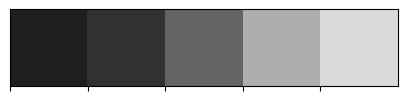

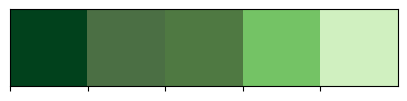

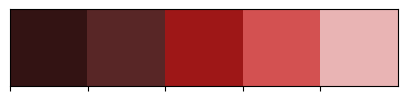

In [2]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [3]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [4]:
import zipfile

# Specify the path to the zip file
zip_file_path = '/content/Tomurimgs.zip'

# Specify the target directory to extract the contents
extracted_dir = '/content/data'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

In [5]:
X_train = []
y_train = []
image_size = 150

train_path = '/content/data/Training'
test_path = '/content/data/Testing'

for i in labels:
    folderPath = os.path.join(train_path, i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join(test_path, i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (image_size, image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 198.50it/s]


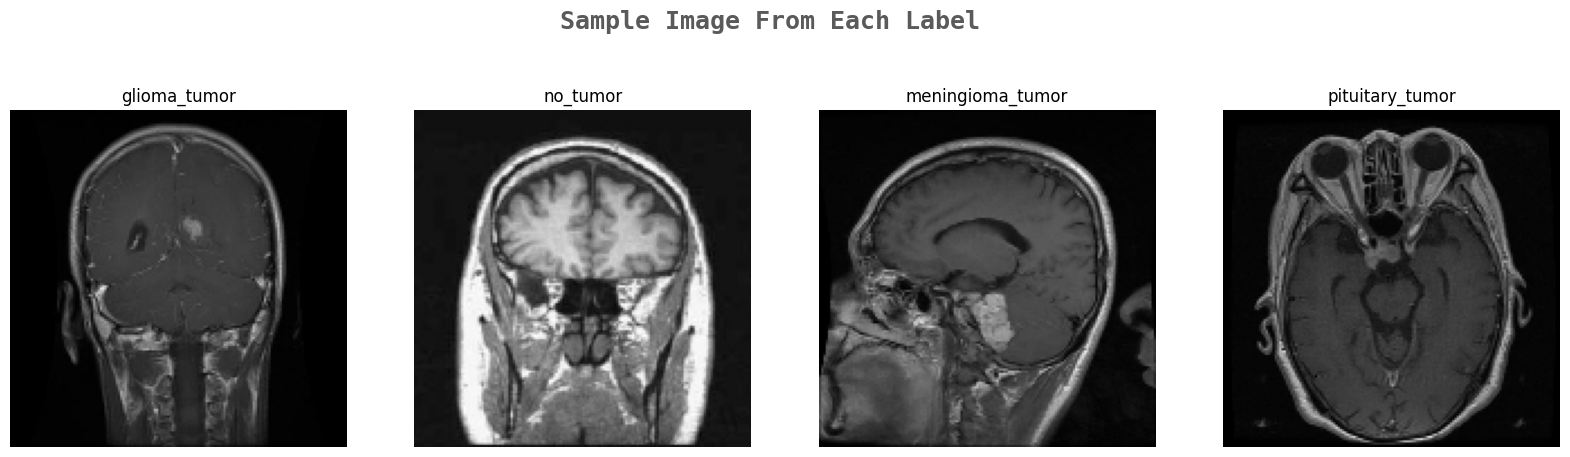

In [6]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [7]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [8]:
X_train.shape

(3264, 150, 150, 3)

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [10]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [49]:
#Pseudo color Function
def apply_pseudo_color(img, label):
    mask = img.sum(axis=2) > 0
    colored_img = np.zeros_like(img)

    if label == 'glioma_tumor':
        colored_img[mask] = [255, 0, 0]
    elif label == 'meningioma_tumor':
        colored_img[mask] = [0, 0, 255]
    elif label == 'pituitary_tumor':
        colored_img[mask] = [0, 255, 0]
    elif label == 'no_tumor':
        colored_img = img

    return colored_img

In [12]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [13]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [14]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [15]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [16]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
83/83 [==============================] - ETA: 0s - loss: 0.5079 - accuracy: 0.8120
Epoch 1: val_accuracy improved from -inf to 0.84014, saving model to effnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


83/83 [==============================] - 53s 171ms/step - loss: 0.5079 - accuracy: 0.8120 - val_loss: 0.4615 - val_accuracy: 0.8401 - lr: 0.0010
Epoch 2/12
83/83 [==============================] - ETA: 0s - loss: 0.2123 - accuracy: 0.9258
Epoch 2: val_accuracy improved from 0.84014 to 0.84694, saving model to effnet.h5
83/83 [==============================] - 12s 141ms/step - loss: 0.2123 - accuracy: 0.9258 - val_loss: 0.5079 - val_accuracy: 0.8469 - lr: 0.0010
Epoch 3/12
83/83 [==============================] - ETA: 0s - loss: 0.1391 - accuracy: 0.9478
Epoch 3: val_accuracy did not improve from 0.84694
83/83 [==============================] - 11s 134ms/step - loss: 0.1391 - accuracy: 0.9478 - val_loss: 1.1959 - val_accuracy: 0.7313 - lr: 0.0010
Epoch 4/12
83/83 [==============================] - ETA: 0s - loss: 0.1046 - accuracy: 0.9637
Epoch 4: val_accuracy did not improve from 0.84694

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
83/83 [===============

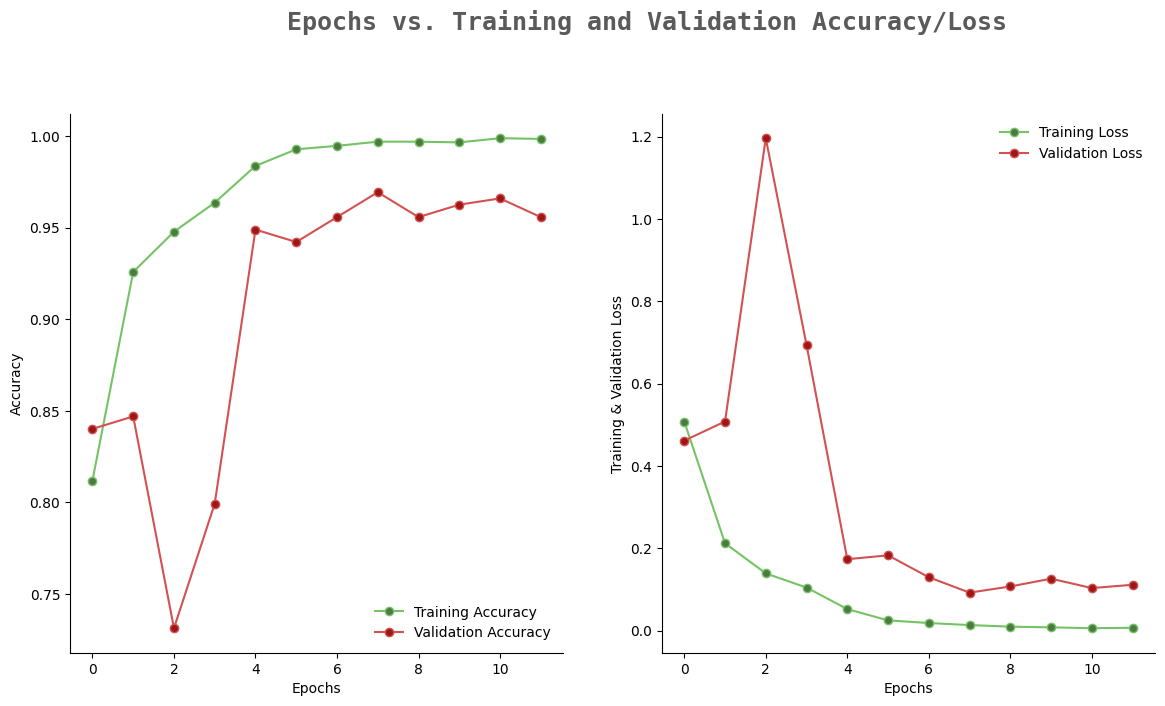

In [17]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [18]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 [==============================] - 2s 81ms/step


In [19]:
# Initialize boolean variables for tracking examples
glioma_tumor_example_shown = False
meningioma_tumor_example_shown = False
pituitary_tumor_example_shown = False

In [20]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        93
           1       0.98      1.00      0.99        51
           2       0.96      0.98      0.97        96
           3       1.00      0.99      0.99        87

    accuracy                           0.98       327
   macro avg       0.98      0.98      0.98       327
weighted avg       0.98      0.98      0.98       327



In [21]:
pred.shape

(327,)

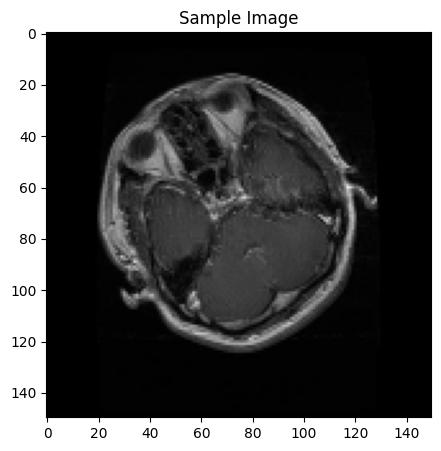

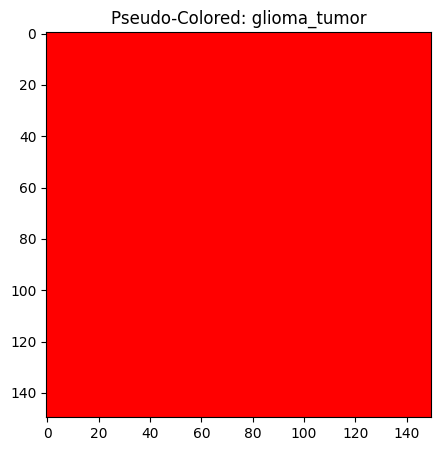

In [44]:
# Test to see if the images are loaded correctly
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(X_train[0], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.title("Sample Image")
plt.show()

# Test the pseudo-coloring function
test_image = X_train[0]
pseudo_colored_img = apply_pseudo_color(test_image, labels[0])
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(pseudo_colored_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.title(f"Pseudo-Colored: {labels[0]}")
plt.show()


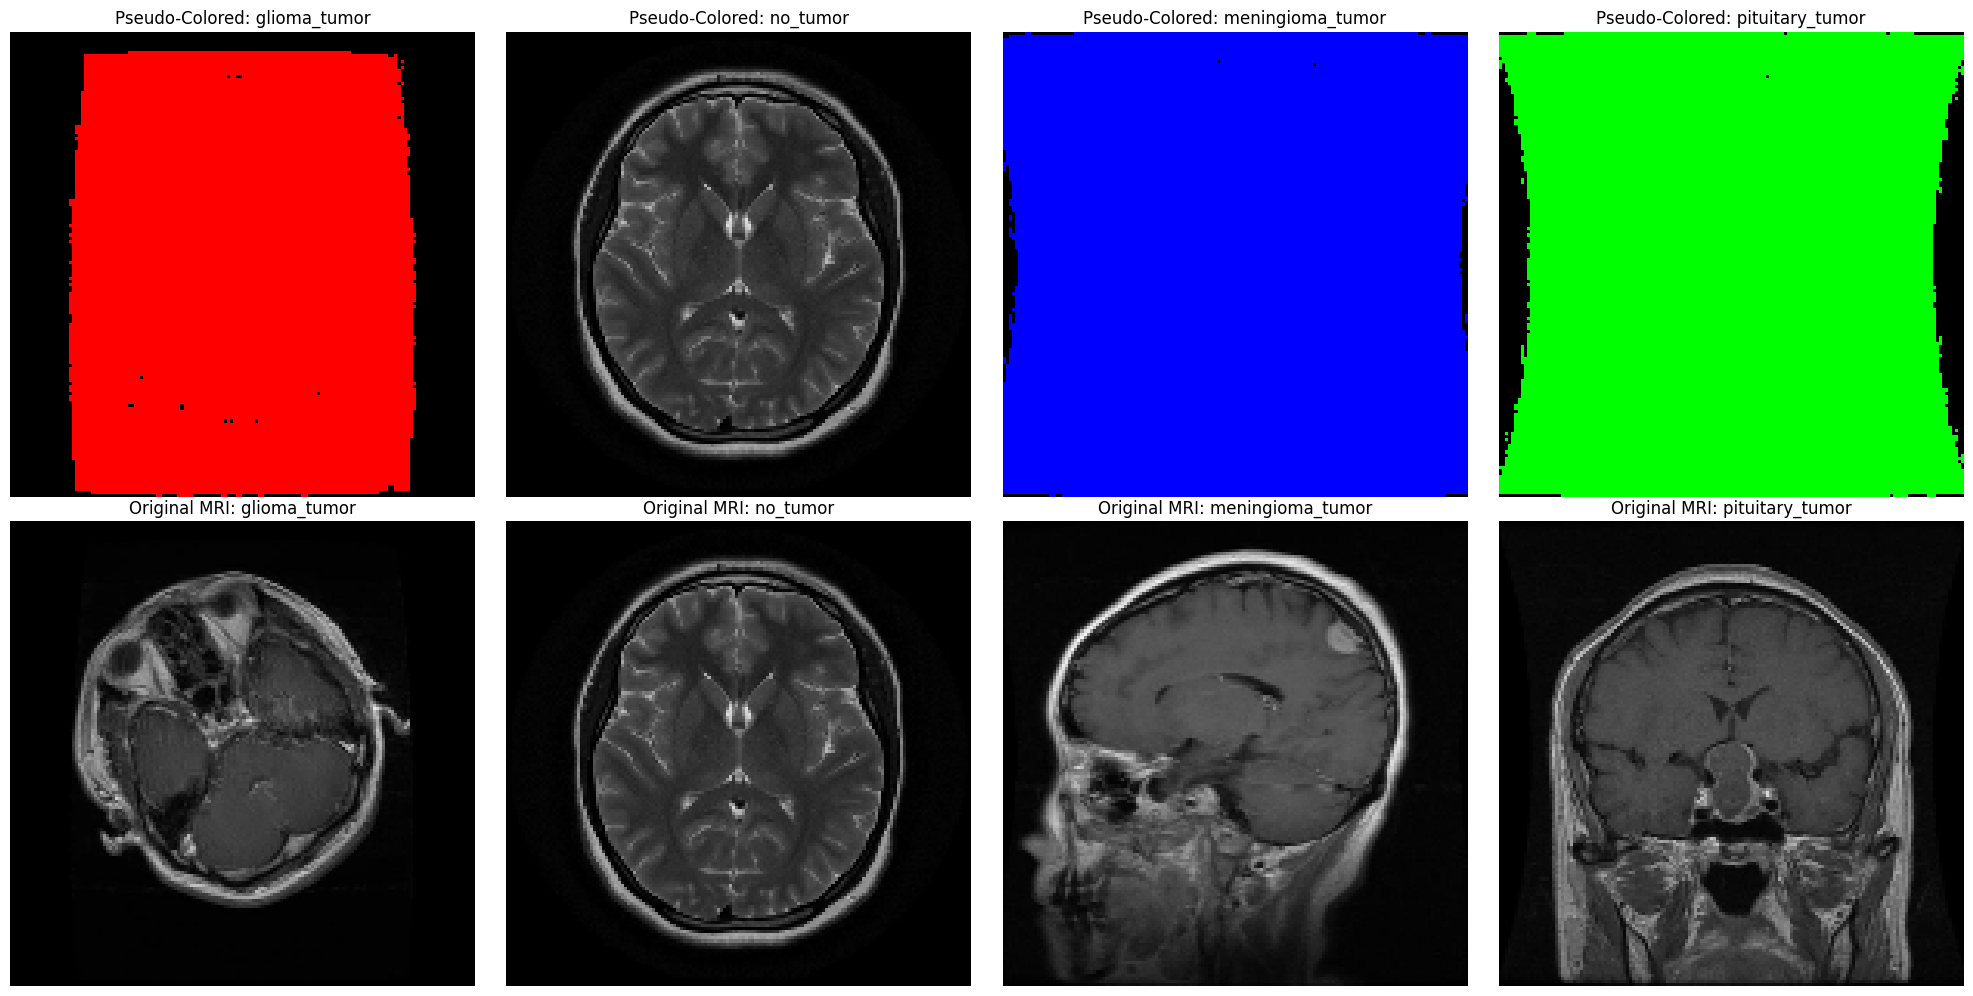

In [53]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 4 columns


for i, label in enumerate(labels):
    label_idx = labels.index(label)
    idx = np.where(y_train_indices == label_idx)[0][0]
    img = X_train_rgb[idx]

    pseudo_colored_img = apply_pseudo_color(img, label)

    ax[0, i].imshow(pseudo_colored_img)
    ax[0, i].set_title(f'Pseudo-Colored: {label}')
    ax[0, i].axis('off')

    ax[1, i].imshow(img)
    ax[1, i].set_title(f'Original MRI: {label}')
    ax[1, i].axis('off')

plt.tight_layout()
plt.show()
